In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"
import matplotlib
from matplotlib import rcParams
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable

rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 14

import numpy as np
import pandas as pd
import seaborn as snb
import copy
import sys
sys.path.append('/home/jdli/TransSpectra/')

import astropy.io.fits as fits
from astropy.table import Table

import numpy as np
%load_ext autoreload
%autoreload 2
import torch
from torch import nn
from torch.utils.data import DataLoader
from transformer import TransformerReg
# from train_ap14 import ASPCAP
from data import AP_fakeprlx
from tqdm import tqdm


In [4]:
! ls /data/jdli/sdss/model

ap_prlx_trsfm_221018.pt		      ap_prlx_trsfm_error221023B_nnNorm.pt
ap_prlx_trsfm_221019.pt		      trsfm_221025A.pt
ap_prlx_trsfm_error221020.pt	      trsfm_221025B.pt
ap_prlx_trsfm_error221021A.pt	      trsfm_221028_fakeA.pt
ap_prlx_trsfm_error221021B.pt	      trsfm_221029A.pt
ap_prlx_trsfm_error221023A_nnNorm.pt


In [2]:
data_dir = "/data/jdli/sdss/"
tr_file = "hogg19_spec_nnnorm_tr.npy"

device = torch.device('cuda:0')
TOTAL_NUM = 6000
BATCH_SIZE = 4

apdata = AP_fakeprlx(data_dir+tr_file, 
                     total_num=6000, part_train=True, device=device)

A_size = int(0.5*(len(apdata)))
B_size = len(apdata) - A_size

A_dataset, B_dataset = torch.utils.data.random_split(apdata, [A_size, B_size], 
                                                     generator=torch.Generator().manual_seed(42))
print(len(A_dataset), len(B_dataset),)

A_loader = DataLoader(A_dataset, batch_size=BATCH_SIZE, )
B_loader = DataLoader(B_dataset, batch_size=BATCH_SIZE, )

3000 3000


In [3]:
## Model parameters
dim_val = 64 # This can be any value divisible by n_heads. 512 is used in the original transformer paper.
n_heads = 4 # The number of attention heads (aka parallel attention layers). dim_val must be divisible by this number
n_decoder_layers = 2 # Number of times the decoder layer is stacked in the decoder
n_encoder_layers = 2 # Number of times the encoder layer is stacked in the encoder
input_size = 1 # The number of input variables. 1 if univariate forecasting.
enc_seq_len = 7514 # length of input given to encoder. Can have any integer value.
dec_seq_len = 2 # length of input given to decoder. Can have any integer value.
output_sequence_length = 2 # Length of the target sequence, i.e. how many time steps should your forecast
max_seq_len = 7514 # What's the longest sequence the model will encounter? Used to make the positional encoder
model = TransformerReg(dim_val=dim_val, input_size=input_size, 
                       batch_first=True, dec_seq_len=dec_seq_len, 
                       out_seq_len=output_sequence_length, n_decoder_layers=n_decoder_layers,
                       n_encoder_layers=n_encoder_layers, n_heads=n_heads,
                       max_seq_len=max_seq_len,
                       ).to(device)

In [4]:
model_name = "model/trsfm_221028_fakeA.pt"

model.load_state_dict(torch.load(data_dir+model_name))

<All keys matched successfully>

In [6]:
def predict(data_loader, model):
    
    out_lst, y_lst = np.array([]), np.array([])
    id_lst = []

    with torch.no_grad():
        for data in tqdm(data_loader):
            output = model(data['x'], data['y'])
            out_lst = np.append(out_lst, output.cpu().numpy())
            y_lst   = np.append(y_lst, data['y'].cpu().numpy())
            # id_lst = np.append(id_lst, data['id'])
            del output, data

    out_lst, y_lst = np.array(out_lst).reshape(-1,2), np.array(y_lst).reshape(-1,2)
    return out_lst, y_lst


out_lst_B, y_lst_B = predict(B_loader, model)



100%|██████████████████████████████████████████████████████████████████████| 750/750 [01:13<00:00, 10.21it/s]


In [7]:
def draw_compare(out_lst, y_lst, errorbar=True):
    xx = np.linspace(-0.5, 1.5)
    
    norm_res = y_lst[:,0]-out_lst[:,0]
    print("residuals mean : %.2f, scatter : %.2f "%(np.nanmedian(norm_res), np.nanstd(norm_res)))
    print("residuals/y mean : %.2f percent"%(100./np.nanmedian(y_lst[:,0]/norm_res)))

    varpi_bin = np.linspace(-0.3, 1.3, 10)
    e_varpi = []

    for i in range(len(varpi_bin)-1):
        ind = (y_lst[:,0]>varpi_bin[i]) & (y_lst[:,0]<=varpi_bin[i+1])

        e_varpi.append(np.median(y_lst[:,1][ind]))
    
    fig, ax = plt.subplots(1,1, figsize=(6,6),  sharex=True)
    ax.plot(xx, xx, ls=':', lw=3, c='k', zorder=5)
    
    if errorbar:
        ax.errorbar(y_lst[:,0], out_lst[:,0],
                      xerr=y_lst[:,1], yerr=np.abs(out_lst[:,1]),
                     capthick=0.01, fmt='.', capsize=0, c='royalblue', alpha=0.1, zorder=4)
    else:
        ax.scatter(y_lst[:,0], out_lst[:,0], s=1,
                   marker='.', c='royalblue', alpha=0.5, zorder=4)

    ax.set_xlim([-0.3, 1.2]);
    ax.set_ylim([-0.3, 1.2]);
    ax.set_ylabel(r"Trans. $\varpi$ (mas)");
    ax.annotate("scatter = %.4f mas"%(np.nanstd(norm_res)), 
                (0.58, 0.35), xycoords="figure fraction",zorder=3)
    ax.annotate("  bias   = %.4f mas"%(np.nanmean(norm_res)), 
                (0.58, 0.40), xycoords="figure fraction",zorder=3)
    
    divider = make_axes_locatable(ax)
    ax2 = divider.append_axes("bottom", size="33%", pad=0)

    norm_res = y_lst[:,0]-out_lst[:,0]
    ax.figure.add_axes(ax2)
    ax2.scatter(y_lst[:,0], norm_res, color="crimson", s=1, zorder=5)
    ax2.axhline(y=0, c='k', zorder=4, lw=3, ls=":")
    ax2.set_xlabel(r"Gaia $\varpi$ (mas)");
    ax2.set_ylim([-0.42, 0.42]);
    ax2.set_xlim([-0.3, 1.2]);
    ax2.set_ylabel(r'$\Delta \varpi$ (mas)');

    for i in range(len(varpi_bin)-1):
        ax2.axhspan(-e_varpi[i], e_varpi[i], varpi_bin[i], varpi_bin[i+1],
                    facecolor='grey', alpha=0.6, zorder=6)
    ax.set_xticks([]);

    return fig, ax

residuals mean : 0.00, scatter : 0.03 
residuals/y mean : 16.11 percent


/data/jdli/anaconda3/envs/gaia/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/data/jdli/anaconda3/envs/gaia/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


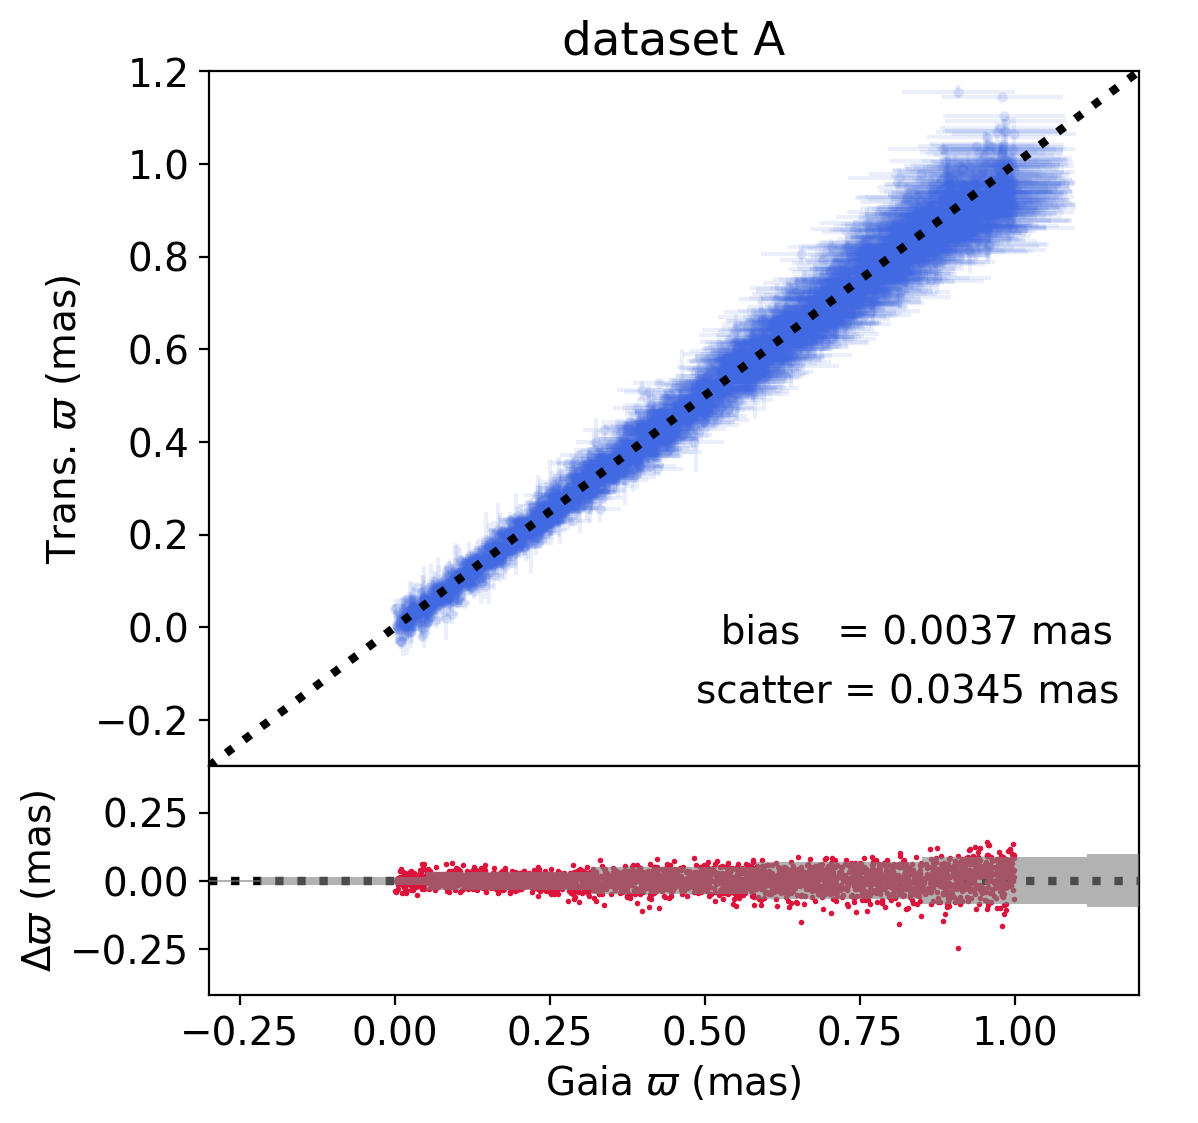

In [8]:

fig, ax = draw_compare(out_lst_B, y_lst_B)
ax.set_title("dataset A");


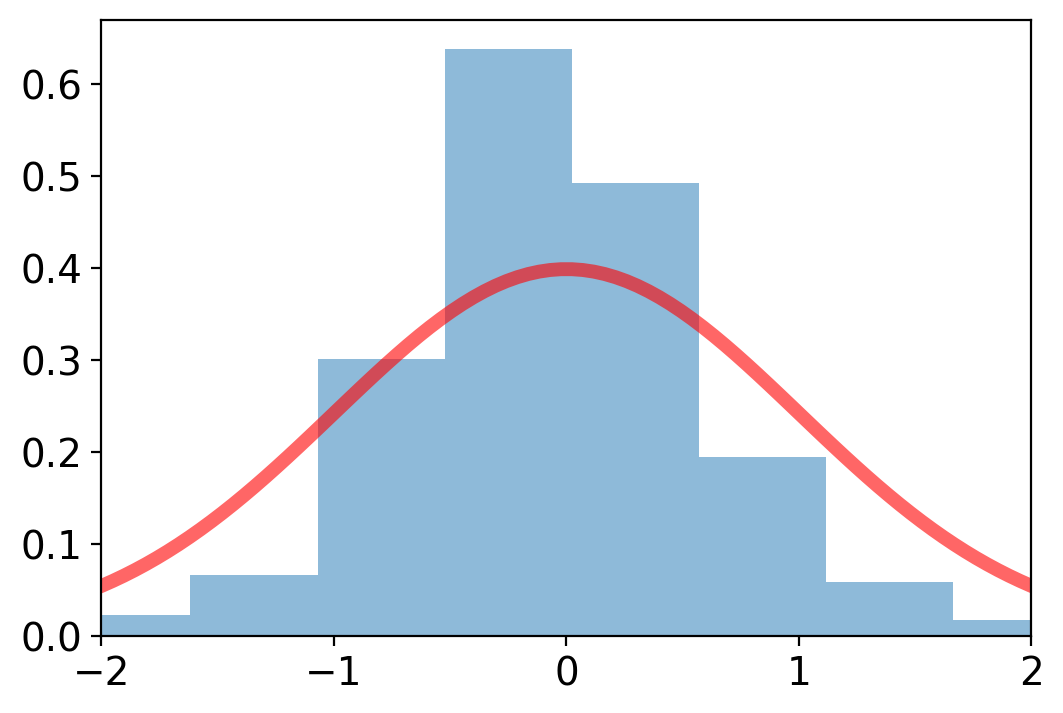

In [10]:
from scipy.stats import norm

xx = np.linspace(norm.ppf(0.01), norm.ppf(0.99), 100)
yy = norm.pdf(xx, 0, 1)

fig, ax = plt.subplots(1,1, figsize=(6,4))
ax.hist((out_lst_B[:,0]-y_lst_B[:,0])/np.sqrt(y_lst_B[:,1]**2+out_lst_B[:,1]**2),
        bins=100, alpha=0.5, density=True);
ax.plot(xx, yy, 'r-', lw=5, alpha=0.6)
ax.set_xlim([-2, 2]);